LightGBM（Light Gradient Boosting Machine）是一个非常灵活和强大的梯度提升框架，它提供了许多可以调整的参数。下面是一些常见参数及其影响：

1. **num_leaves**：
   - 描述：树中的叶子数量。
   - 影响：较多的叶子可以增加模型的复杂度和学习能力，但也可能导致过拟合。较少的叶子可以使模型更简单、更稳定。

2. **min_data_in_leaf**：
   - 描述：叶子节点所需的最小数据量。
   - 影响：较大的值可以防止树过度生长，有助于防止过拟合。较小的值允许树更深入地学习数据的细节。

3. **max_depth**：
   - 描述：树的最大深度。
   - 影响：较深的树可以增加模型的复杂度，可能提高性能但也可能导致过拟合。较浅的树使模型更简单、更稳定。

4. **learning_rate**：
   - 描述：学习速率，决定了每棵树对结果的贡献。
   - 影响：较小的学习率需要更多的树来进行训练，但通常可以提高模型的最终性能。较大的学习率训练速度快，但可能导致模型性能不稳定。

5. **n_estimators**：
   - 描述：要构建的树的数量。
   - 影响：更多的树可以增加模型的性能，但也可能导致过拟合。较少的树可以加快训练速度。

6. **subsample** 和 **colsample_bytree**：
   - 描述：分别用于指定用于训练每棵树的样本比例和特征比例。
   - 影响：这些参数有助于提供更好的正则化，可以提高模型的泛化能力。

7. **is_unbalance** 或 **scale_pos_weight**：
   - 描述：用于处理不平衡的数据集。
   - 影响：有助于模型在少数类样本上表现得更好。

8. **early_stopping_rounds**：
   - 描述：如果模型的验证性能在指定的回合数内没有改善，则停止训练。
   - 影响：有助于防止过拟合，提高计算效率。

9. **force_col_wise** 或 **force_row_wise**：
   - 描述：用于优化内存使用和加速训练，特别是在处理大型数据集时。
   - 影响：根据数据的特性选择适当的方法可以加快训练速度。


In [1]:
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.utils import resample
import numpy as np
import pandas as pd
import lightgbm as lgb
from sklearn.model_selection import StratifiedKFold


# file_path = "E:\竞赛\服创赛-A08\data\\analyzed_data.csv"
file_path = "E:\竞赛\服创赛-A08\data\process_data.csv"
# file_path = "E:\竞赛\服创赛-A08\data\欺诈手段特征集.xlsx"
data = pd.read_csv(file_path)

# data = pd.read_excel(file_path)


In [24]:
# !pip install lightgbm

In [38]:
# 根据相关性和特征重要性手动删除特征

data = data.drop(columns=['起付线标准金额_MAX','高价材料发生金额_SUM','公务员医疗补助基金支付金额_SUM',
                          '残疾军人补助_SUM','城乡优抚补助_SUM','最高限额以上金额_SUM','其它申报金额_SUM','成分输血申报金额_SUM',
                          '住院天数_SUM','交易时间YYYY_NN','BZ_民政救助','BZ_城乡优抚','手术费自费金额_SUM'])


data.head()

,个人编码,一天去两家医院的天数,就诊的月数,月就诊天数_MAX,月就诊天数_AVG,月就诊医院数_MAX,月就诊医院数_AVG,就诊次数_SUM,月就诊次数_MAX,月就诊次数_AVG,...,出院诊断病种名称_NN,出院诊断LENTH_MAX,药品在总金额中的占比,个人支付的药品占比,检查总费用在总金额占比,个人支付检查费用占比,治疗费用在总金额占比,个人支付治疗费用占比,是否挂号,RES
0,3.521200e+14,0,6,7,5.666667,3,2.166667,34,7,5.666667,...,4,29.0,0.939194,0.004262,0.050817,0.0,0.007434,0.0,1,0
1,3.521200e+14,0,6,4,2.500000,2,1.333333,15,4,2.500000,...,3,20.0,0.955626,0.002982,0.030815,0.0,0.013398,0.0,1,0
2,3.521200e+14,8,6,8,6.166667,3,2.166667,45,9,7.500000,...,4,29.0,0.783610,0.000332,0.000000,0.0,0.195087,0.0,0,0
3,3.521200e+14,0,6,6,3.666667,2,1.833333,23,6,3.833333,...,5,16.0,0.458649,0.000184,0.000000,0.0,0.541351,0.0,0,0
4,3.521200e+14,0,6,5,4.333333,1,1.000000,26,5,4.333333,...,2,33.0,0.983726,0.000316,0.000000,0.0,0.016274,0.0,0,0


In [39]:
# 在结尾处获取要删除的特征列表
# data = data.drop(columns=list(features_to_remove))
# data.head()

In [ ]:
# 选择重要性排名最后n个特征--可以手动重复此步骤逐步删除
# features_to_remove = feature_importances_df.tail(5)['Feature Name']

# # 删除这些特征
# data = data.drop(columns=features_to_remove)
# data.head()

In [3]:
# 分离特征

df_majority = data[data.RES == 0]
df_minority = data[data.RES == 1]

In [2]:

X = data.drop('RES', axis=1)
y = data['RES']



In [3]:
# 定义一个函数，用于单独训练和返回模型
def get_specific_ratio_model(X, y, specific_ratio):
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=123)
    final_model = None

    for train_index, test_index in skf.split(X, y):
        # 分割数据
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        # 分离多数和少数类
        X_train_majority = X_train[y_train == 0]
        X_train_minority = X_train[y_train == 1]

        # 执行欠采样
        majority_sample_size = int(len(X_train_minority) * specific_ratio)
        X_train_majority_downsampled = resample(X_train_majority, 
                                                replace=False,
                                                n_samples=majority_sample_size,
                                                random_state=123)
        y_train_majority_downsampled = y_train.loc[X_train_majority_downsampled.index]

        # 合并数据
        X_train_downsampled = pd.concat([X_train_majority_downsampled, X_train_minority])
        y_train_downsampled = pd.concat([y_train_majority_downsampled, y_train[y_train == 1]])
        
        # weights = np.where(y_train_downsampled == 1, 50, 1)
        
        params = {
            'subsample':0.7,
            'colsample_bytree':0.7,
            'random_state':42, 
        'is_unbalance':True,
        'n_estimators':100
        }
        # 创建LightGBM模型
        lgb_model = lgb.LGBMClassifier(**params)
        # 训练模型
        lgb_model.fit(X_train_downsampled, y_train_downsampled)
        # 更新最后一个模型
        final_model = lgb_model
        # 预测测试集
        y_pred = final_model.predict(X_test)
        
        # 计算性能指标
        classification_rep = classification_report(y_test, y_pred)
        auc_score = roc_auc_score(y_test, final_model.predict_proba(X_test)[:, 1])
        
        # 打印评估结果
        print(classification_rep)
        print("AUC Score:", auc_score)
    
    return final_model,auc_score,X_train,y_train,X_test,y_test

In [16]:
# 获取比例为n:1的模型(降低比例会略微提高AUC，但不显著)
specific_ratio = 6
final_model,auc_score,X_train,y_train,X_test,y_test = get_specific_ratio_model(X, y, specific_ratio)

# 输出比例为n的模型
final_model,auc_score

[LightGBM] [Info] Number of positive: 635, number of negative: 3810
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002999 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11973
[LightGBM] [Info] Number of data points in the train set: 4445, number of used features: 72
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.142857 -> initscore=-1.791759
[LightGBM] [Info] Start training from score -1.791759
              precision    recall  f1-score   support

           0       0.98      0.94      0.96      3042
           1       0.39      0.71      0.50       158

    accuracy                           0.93      3200
   macro avg       0.69      0.83      0.73      3200
weighted avg       0.95      0.93      0.94      3200

AUC Score: 0.9354729982772826
[LightGBM] [Info] Number of positive: 635, number of negative: 3810
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing wa

(LGBMClassifier(colsample_bytree=0.7, is_unbalance=True, random_state=42,
                subsample=0.7),
 0.918900808448065)

In [5]:
# 预测测试集
y_pred = final_model.predict(X_train)

# 计算性能指标
classification_rep = classification_report(y_train, y_pred)
auc_score = roc_auc_score(y_train, final_model.predict_proba(X_train)[:, 1])

# 打印评估结果
print(classification_rep)
print("AUC Score:", auc_score)

              precision    recall  f1-score   support

           0       1.00      0.95      0.97     12166
           1       0.49      1.00      0.66       634

    accuracy                           0.95     12800
   macro avg       0.74      0.97      0.81     12800
weighted avg       0.97      0.95      0.96     12800

AUC Score: 0.9960891941185837


In [6]:
X_train.shape

(12800, 81)

In [10]:
# 划分训练集和测试集
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=123)

In [11]:
# 创建LightGBM模型
lgb_model = lgb.LGBMClassifier(random_state=42, 
                                is_unbalance=True,
                                n_estimators=228)
        # 训练模型
lgb_model = lgb_model.fit(X_train, y_train)
        # 更新最后一个模型
final_model = lgb_model




# 预测测试集
y_pred = final_model.predict(X_test)

# 计算性能指标
classification_rep = classification_report(y_test, y_pred)
auc_score = roc_auc_score(y_test, final_model.predict_proba(X_test)[:, 1])

# 打印评估结果
print(classification_rep)
print("AUC Score:", auc_score)

[LightGBM] [Info] Number of positive: 565, number of negative: 10635
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011420 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12747
[LightGBM] [Info] Number of data points in the train set: 11200, number of used features: 72
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.050446 -> initscore=-2.935080
[LightGBM] [Info] Start training from score -2.935080
              precision    recall  f1-score   support

           0       0.97      0.98      0.98      4572
           1       0.58      0.41      0.48       228

    accuracy                           0.96      4800
   macro avg       0.77      0.70      0.73      4800
weighted avg       0.95      0.96      0.95      4800

AUC Score: 0.9144017359672146


In [15]:
# 设置阈值
threshold = 0.35

# 以概率形式获取预测结果
y_probs = final_model.predict_proba(X_test)[:, 1] # 获取正类的概率

# 应用阈值
y_pred_thresh = np.where(y_probs > threshold, 1, 0)

# 生成分类报告
classification_report_06 = classification_report(y_test, y_pred_thresh)

print(classification_report_06)

              precision    recall  f1-score   support

           0       0.99      0.90      0.94      3041
           1       0.27      0.74      0.40       159

    accuracy                           0.89      3200
   macro avg       0.63      0.82      0.67      3200
weighted avg       0.95      0.89      0.91      3200



In [9]:
from joblib import dump

# 保存模型
model_filename = 'E:\\竞赛\\服创赛-A08\\model\\lgb_undersampling_model.joblib'
dump(final_model, model_filename)

print(f"模型已保存为 {model_filename}")

模型已保存为 E:\竞赛\服创赛-A08\model\lgb_undersampling_model.joblib


In [104]:
lgb_model = final_model

In [105]:
import matplotlib.pyplot as plt
import seaborn as sns
rc = {'font.sans-serif': 'SimHei',
      'axes.unicode_minus': False}
sns.set(context='notebook', style='ticks', rc=rc)


from sklearn.feature_selection import mutual_info_classif
%matplotlib inline
pd.set_option("display.max_columns",100)
pd.set_option('display.max_rows',100)

from pylab import mpl 
plt.rcParams['font.sans-serif'] = ['Microsoft YaHei']  # 设置中文字体
plt.rcParams['axes.unicode_minus'] = False  # 为了显示负号正常

import warnings
warnings.filterwarnings("ignore")

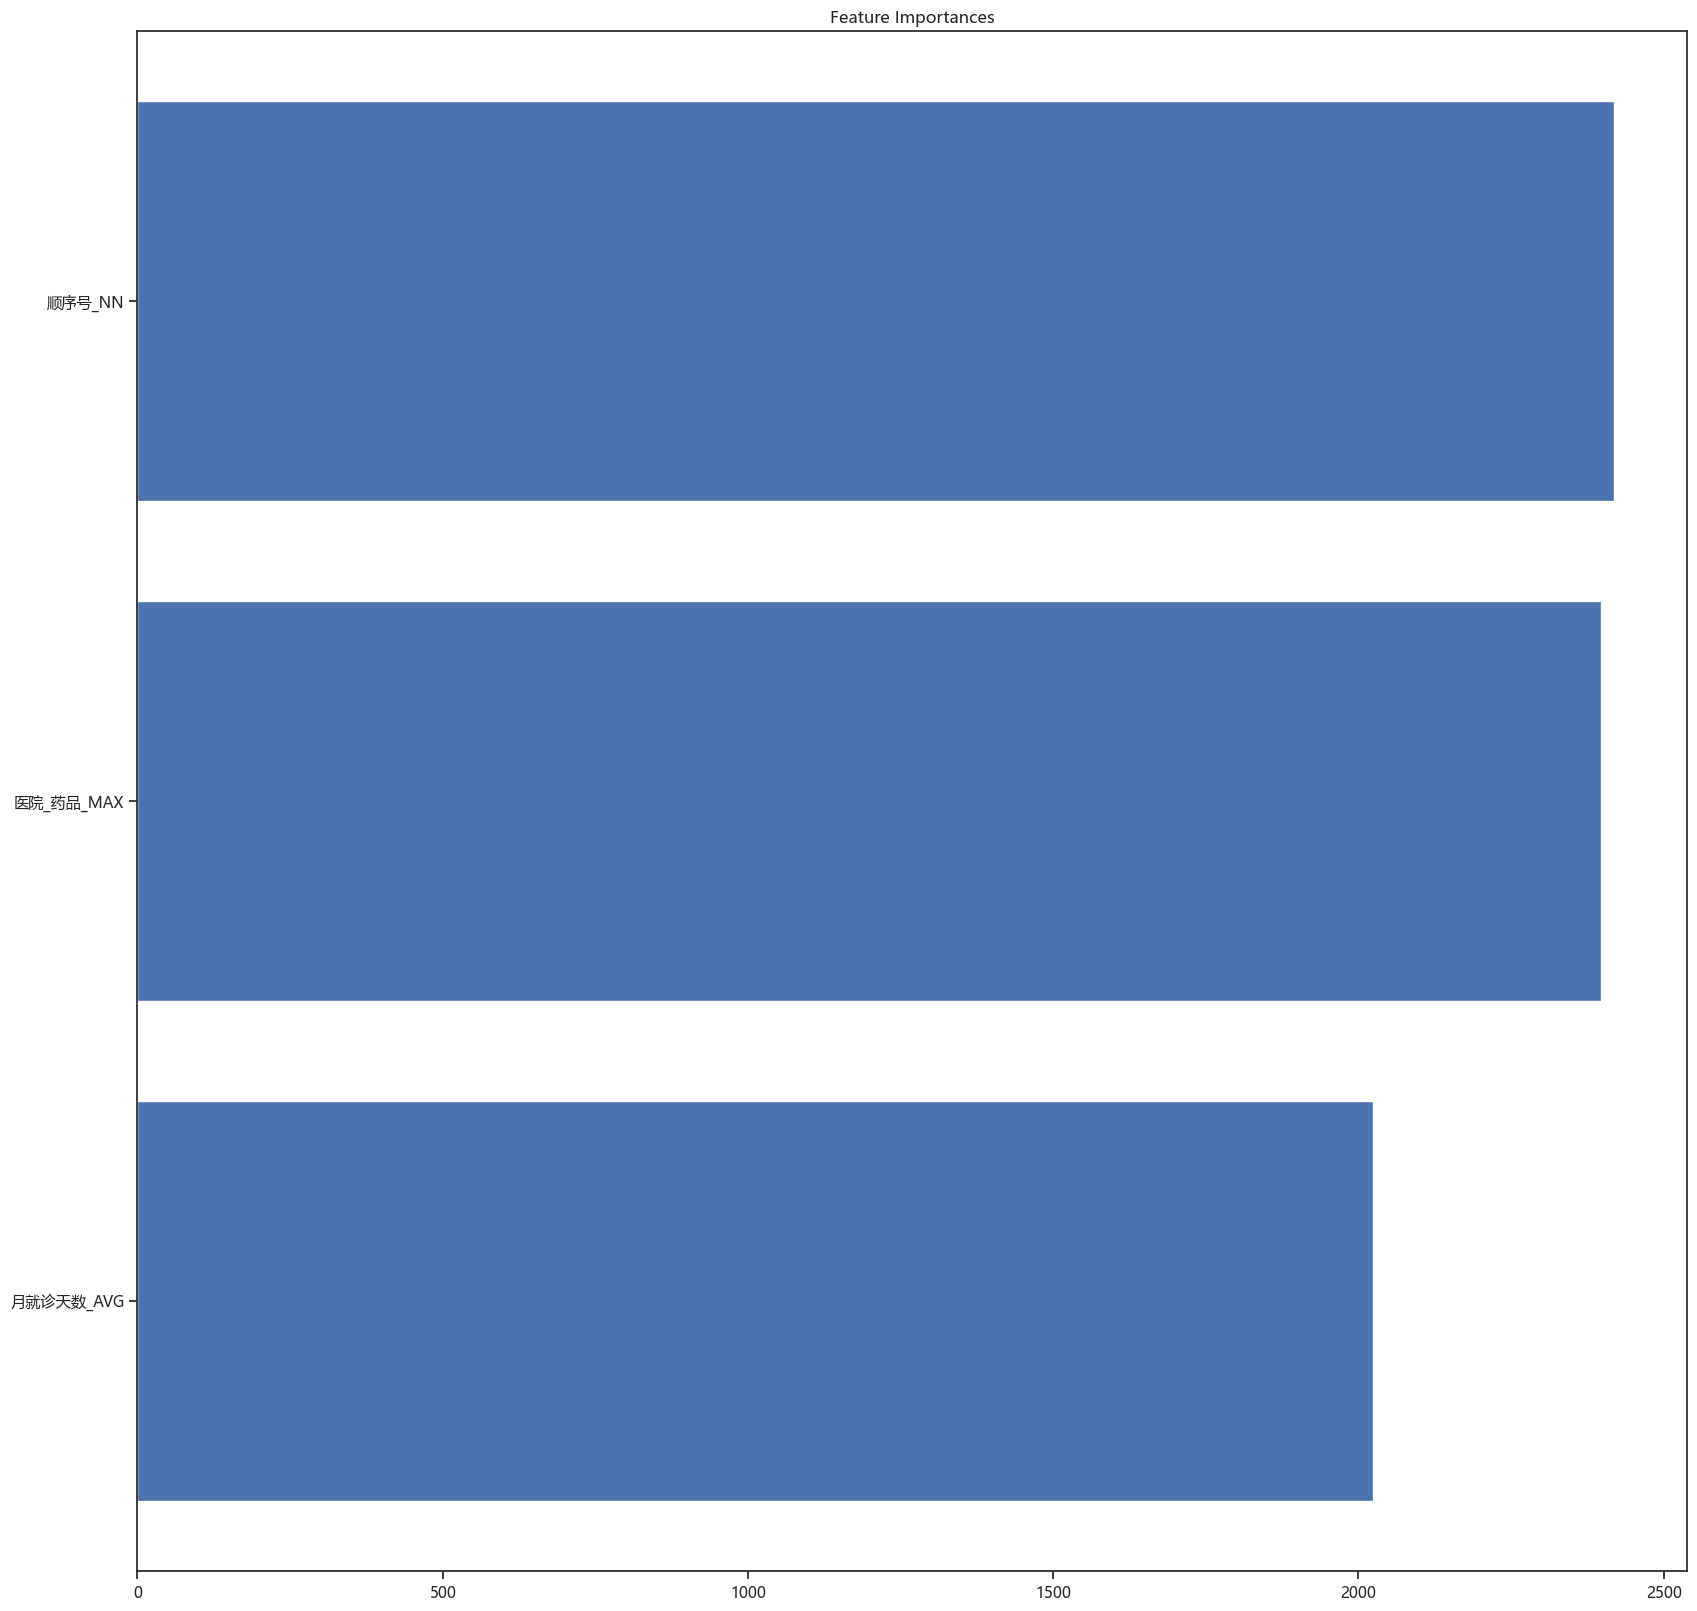

In [106]:
# 获取特征重要性
feature_importance = lgb_model.feature_importances_

# 转换为Pandas DataFrame
feature_names = X_train.columns
feature_importances_df = pd.DataFrame({'Feature Name': feature_names, 'Importance': feature_importance})

# 对特征重要性进行排序
feature_importances_df = feature_importances_df.sort_values(by='Importance', ascending=False)

# 可视化特征重要性
plt.figure(figsize=(20, 20))
plt.title('Feature Importances')
plt.barh(feature_importances_df['Feature Name'], feature_importances_df['Importance'])
plt.gca().invert_yaxis()
plt.show()

In [107]:
feature_importances_df

,Feature Name,Importance
2,顺序号_NN,2418
1,医院_药品_MAX,2398
0,月就诊天数_AVG,2024


In [49]:
# 保存模型
from joblib import dump
dump(lgb_model, "E:\竞赛\服创赛-A08\\results\\lgb_model.pkl")

['E:\\竞赛\\服创赛-A08\\results\\lgb_model.pkl']

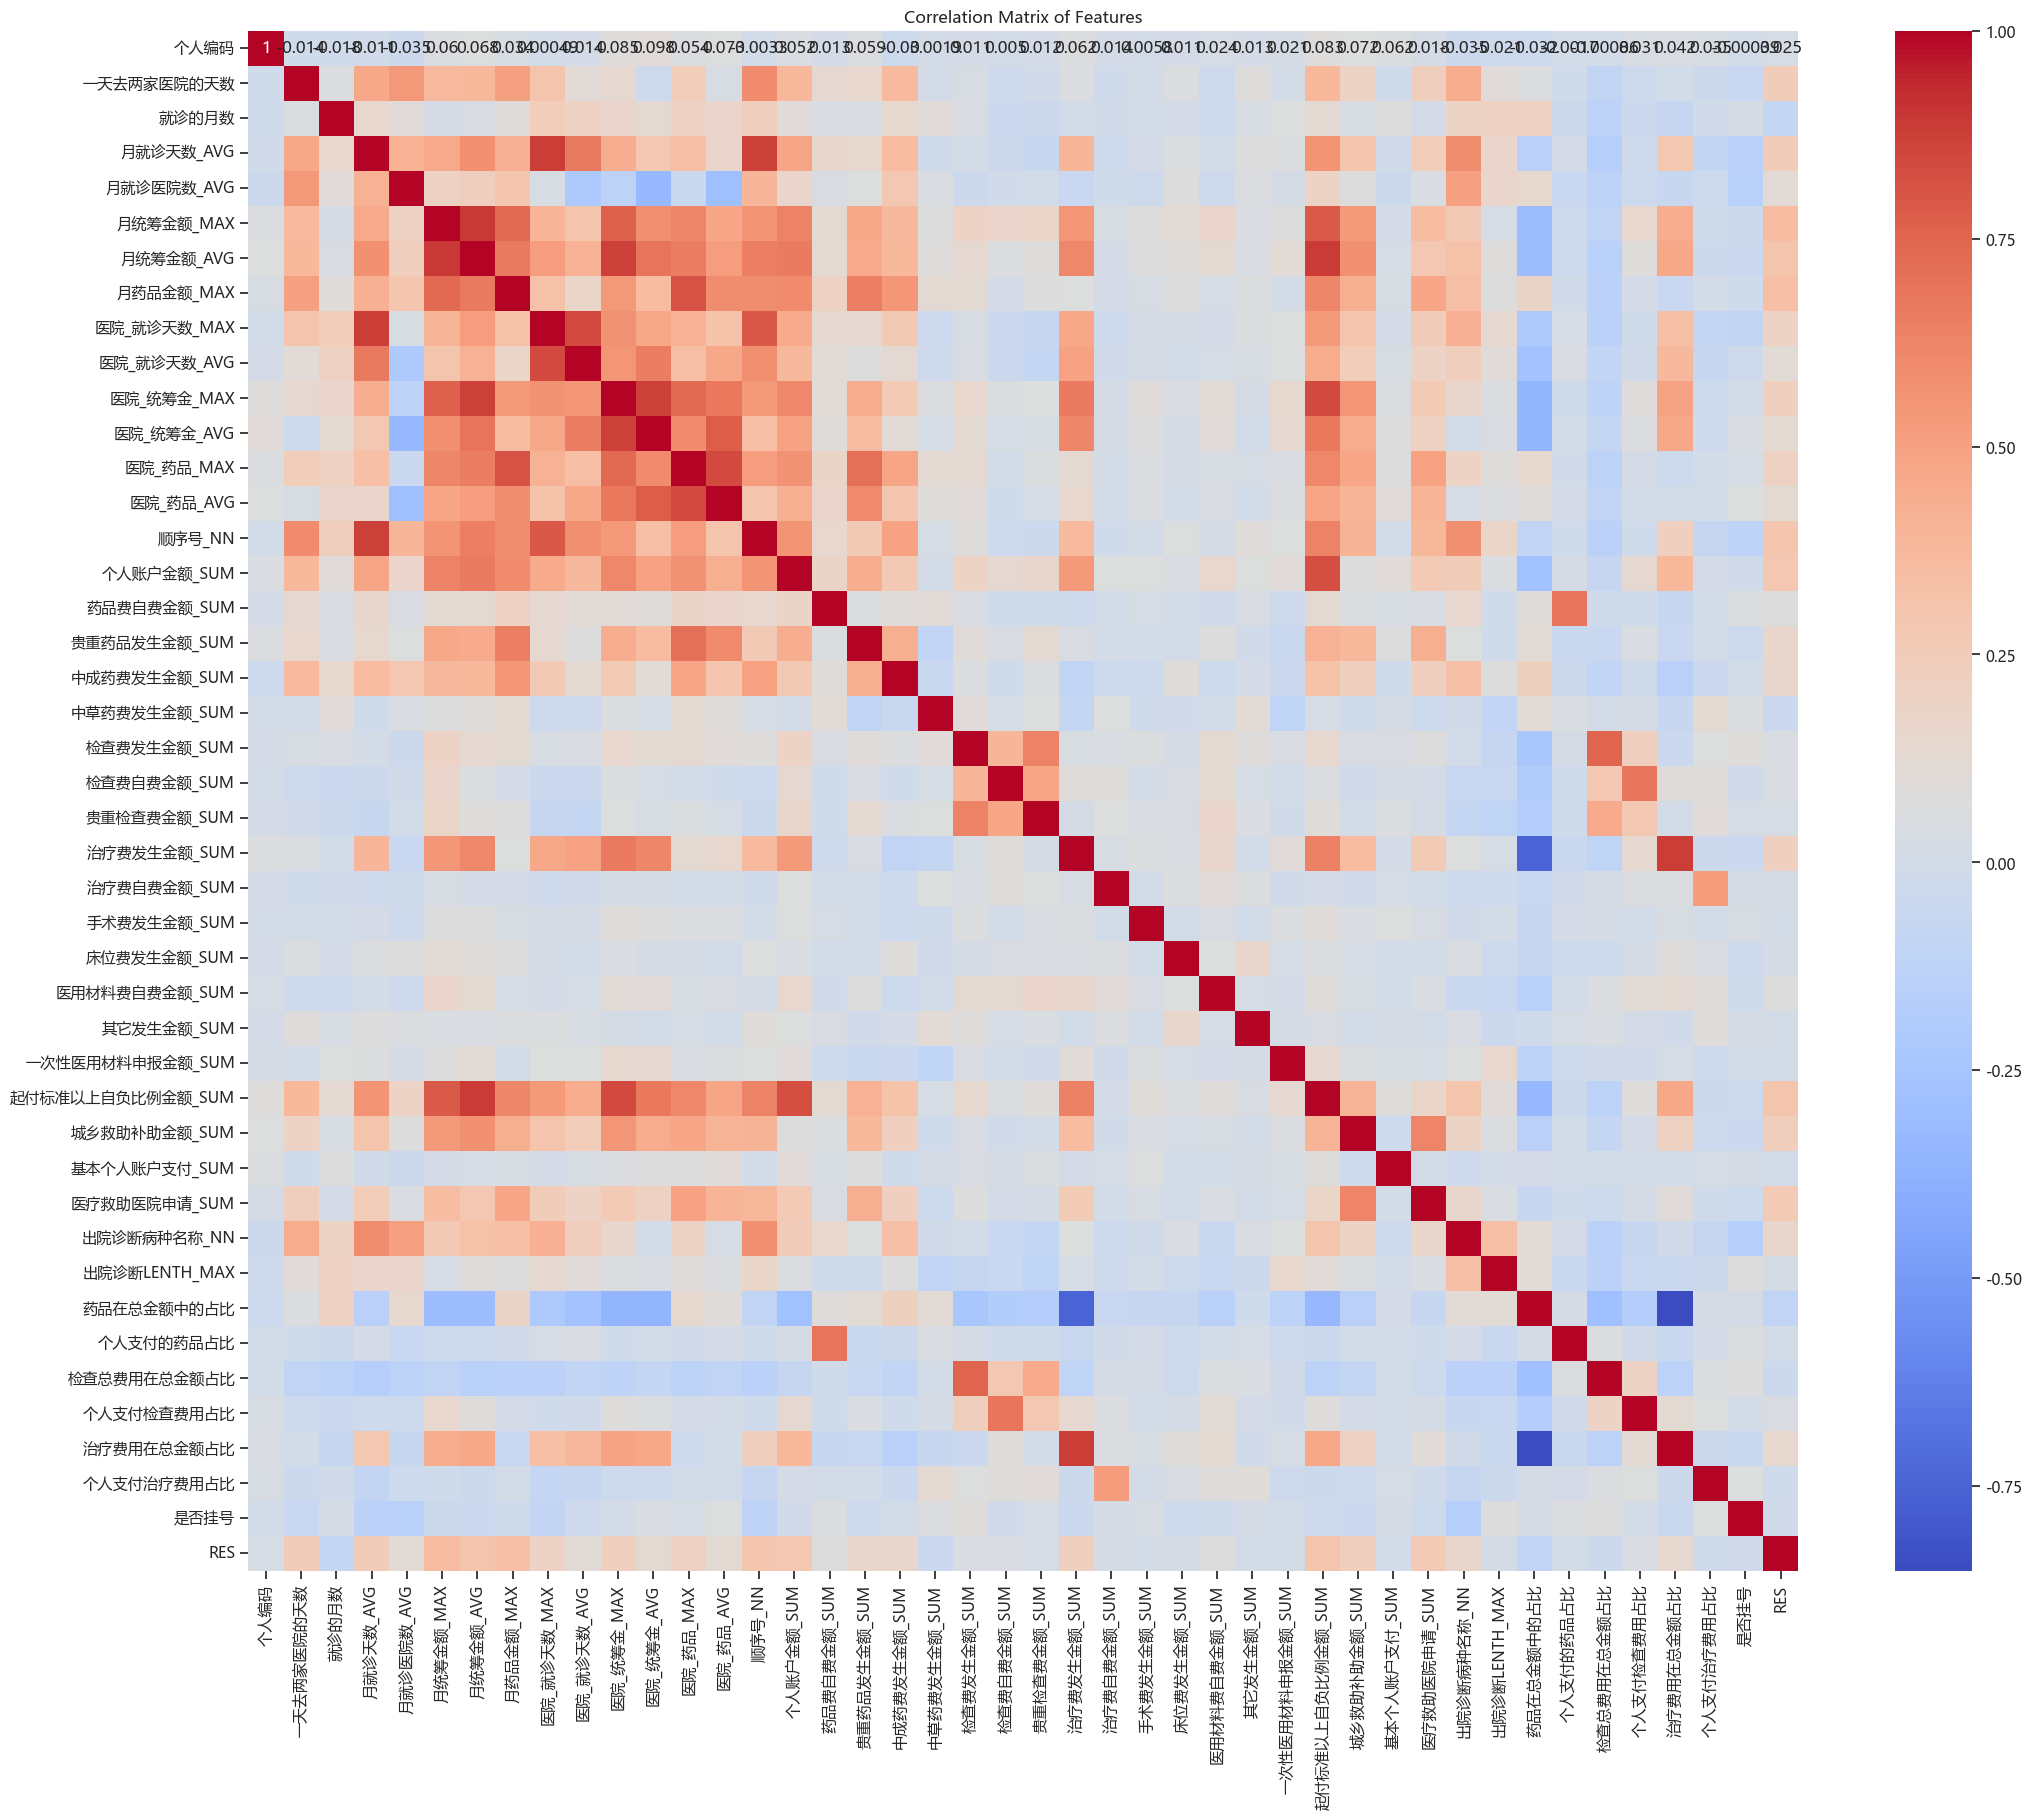

In [50]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
pd.set_option("display.max_columns",100)
pd.set_option('display.max_rows',100)

from pylab import mpl 
plt.rcParams['font.sans-serif'] = ['Microsoft YaHei']  # 设置中文字体
plt.rcParams['axes.unicode_minus'] = False  # 为了显示负号正常


correlation_matrix = data.corr()


plt.figure(figsize=(25, 20))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix of Features')
plt.show()

In [51]:
high_corr_pairs = []

for col in correlation_matrix.columns:
    for row in correlation_matrix.index:
        if (correlation_matrix.loc[row, col] > 0.9) and (col != row):
            # Check if the pair is already added
            if not {(row, col), (col, row)}.intersection(set(high_corr_pairs)):
                high_corr_pairs.append((row, col))

high_corr_pairs

[]

In [52]:
# 初始化要删除的特征列表
# 特征a与特征b高度相关，但是特征a的特征重要性大于b，那么就删除特征b
features_to_remove = set()

for feature1, feature2 in high_corr_pairs:
    # 获取两个特征的重要性
    importance_feature1 = feature_importances_df[feature_importances_df['Feature Name'] == feature1]['Importance'].values[0]
    importance_feature2 = feature_importances_df[feature_importances_df['Feature Name'] == feature2]['Importance'].values[0]

    # 比较重要性并添加较低的一个到删除列表
    if importance_feature1 > importance_feature2:
        features_to_remove.add(feature2)
    else:
        features_to_remove.add(feature1)

# 输出要删除的特征列表
features_to_remove


set()